In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

from pathlib import Path
from analysis import files, collection, emg
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import scipy

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
subject_num = 15
session_num = 15
trial_num = 2

c = collection.Collection("emg_olympics")
# first alphabetical subject in the dict
s = c.subjects[c.subject_names[subject_num]]
# trial
t = s.tasks["center_hold"].sorted_sessions()[session_num].sorted_trials()[trial_num]


## reconstruct EMG filtering

In [4]:
def make_kernel(kernel_length, cutoff_hz, sample_rate_hz, mode="lowpass"):
    # based on https://github.com/bonsai-rx/bonsai/blob/9c4db22dfa43a7b20fb8de7cb4eb079b19cfa027/Bonsai.Dsp/FrequencyFilter.cs#L153
    # Low-pass windowed-sinc filter: http://www.dspguide.com/ch16/4.htm
    cutoffRadians = 2 * np.pi * cutoff_hz / sample_rate_hz
    kernel = np.zeros((kernel_length + 1, 1))
    for i in range(kernel_length):
        normalizer = i - (kernel_length // 2)
        if normalizer == 0: 
            kernel[i] = cutoffRadians
        else:
            kernel[i] = np.sin(cutoffRadians * normalizer) / normalizer

        # Blackman window: http://www.dspguide.com/ch16/1.htm
        kernel[i] = kernel[i] * (0.42 - 0.5 * np.cos(2 * np.pi * i / kernel_length) + 0.08 * np.cos(4 * np.pi * i / kernel_length))

    # Normalize for unit gain
    sum = np.sum(kernel)
    kernel /= sum

    if mode == "highpass":
        kernel *= -1
        # add unit impulse to the center of the kernel
        # in freq domain:
        # k_hp(f) = 1 - k_lp(f)
        kernel[(kernel.shape[0]) // 2] += 1

    return kernel[:-1]

# k = make_kernel(500, 5, 2000)
# plt.plot(k)

def highpass(a):
    highpass_kernel = make_kernel(250, 0.1, 2000, mode='highpass')
    # cut off the end where it's extended for the "full" convolution
    return scipy.signal.convolve2d(a, highpass_kernel, mode="full", boundary="symm")[:-highpass_kernel.shape[0]+2]

def standardize(a, var):
    return (var @ a.T).T

def rectify(a):
    return np.abs(a)

def lowpass(a):
    lowpass_kernel = make_kernel(750, 5.0, 2000, mode='lowpass')
    return scipy.signal.convolve2d(a, lowpass_kernel, mode="full", boundary="symm")[:-lowpass_kernel.shape[0]+2]

def subsample(a):
    return a[::10, :]

def filter_emg(a, var):
    if a.shape[1] != 64:
        raise ValueError(f"incorrect shape for input array: {a.shape}")
    return subsample(lowpass(rectify(standardize(highpass(a), var))))

In [5]:
# filter delay is (window - 1)/(2 * sample_rate)
print(f"{((1000 - 1)/(2*2))} ms")

# half the

# Output delay is the amount of time it takes for a change 
# on the input to fully reflect on the output. It can also be
# expressed in samples and is equal to filter order 
# (window-1). 

# To be precise the group delay of a linear phase FIR filter is (𝑁−1)/2 samples, where 𝑁 is 
# the filter length (i.e. the number of taps). The group delay is constant for all 
# frequencies, because the filter has a linear phase, i.e. its impulse response is symmetrical 
# (or asymmetric). A linear phase means that all frequency components of the input signal 
# experience the same delay, i.e. there are no phase distortions. So for a frequency selective 
# filter (e.g., a low pass filter), if the input signal is in the passband of the filter, the 
# output signal is approximately equal to the input signal delayed by the group delay of the 
# filter. Note that in general FIR filters do not have a linear phase response. In this case, 
# the group delay is a function of frequency.
# https://dsp.stackexchange.com/questions/18435/group-delay-of-the-fir-filter 

# Group delay is the time lag of the amplitude envelopes of 
# the various sinusoidal components of the input signal through 
# the filter. It can also be expressed in samples and is 
# equal to half the filter order ((window-1)/2).

249.75 ms


recorded_filtered:  (293, 64)
raw:  (2920, 64)
highpassed:  (2921, 64)
standardized:  (2921, 64)
rectified:  (2921, 64)
lowpassed:  (2922, 64)
subsampled:  (293, 64)


ValueError: operands could not be broadcast together with shapes (292,) (293,) 

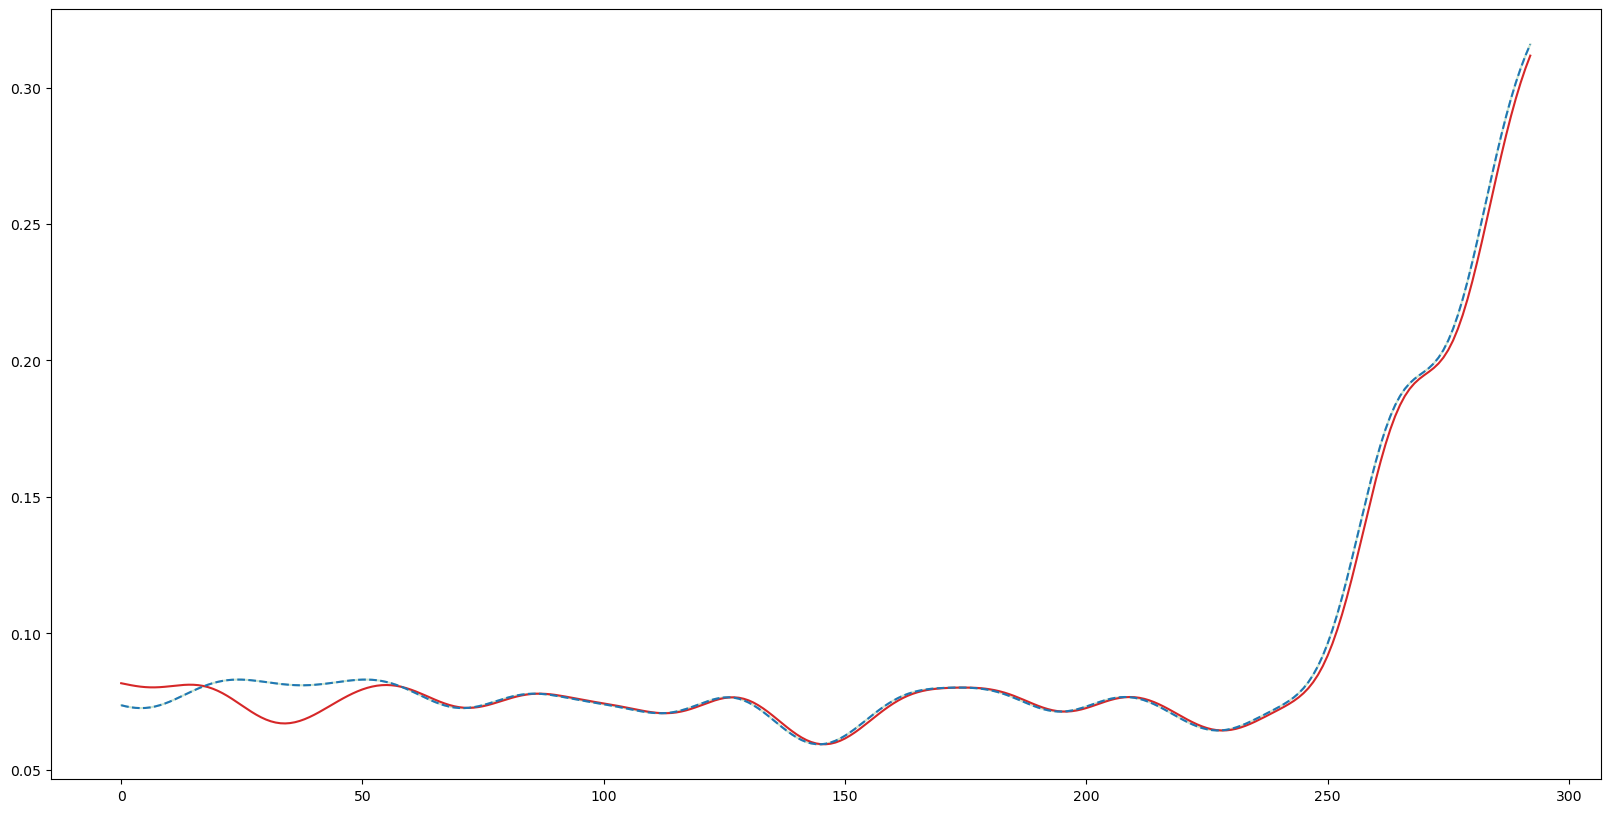

In [6]:
channel = 27

fig, ax = plt.subplots(figsize=(20,10))

# FilteredEMG
recorded_filtered_signal = t.get_filtered_emg()
print("recorded_filtered: ", recorded_filtered_signal.shape)

# raw signal, submatrix for 64 channels
raw_signal = t.get_raw_emg()[:,:64]
print("raw: ", raw_signal.shape)

# highpass
filtered_signal = highpass(raw_signal)
# filtered_signal_1d = scipy.signal.convolve2d(raw_signal[:,channel].reshape(-1,1), highpass_kernel, mode="full", boundary="symm")[:-highpass_kernel.shape[0]+1]
print("highpassed: ", filtered_signal.shape)

# standardize
filtered_signal = standardize(filtered_signal, s.variance)
print("standardized: ", filtered_signal.shape)

# rectify
filtered_signal = rectify(filtered_signal)
print("rectified: ", filtered_signal.shape)

# lowpass 
filtered_signal = lowpass(filtered_signal)
# filtered_signal_1d = scipy.signal.convolve2d(filtered_signal.reshape(-1,1), lowpass_kernel.reshape(-1,1), mode="full", boundary="symm")[:-lowpass_kernel.shape[0]+1]
print("lowpassed: ", filtered_signal.shape)

# subsample
filtered_signal = subsample(filtered_signal)
print("subsampled: ", filtered_signal.shape)
ax.plot(filtered_signal[:, channel], alpha=0.2, c='g')
# ax.plot(filtered_signal, alpha=0.5, c='g')

x = np.linspace(0, filtered_signal.shape[0], recorded_filtered_signal.shape[0])

ax.plot(recorded_filtered_signal[:, channel], c='tab:red', label="Recorded Signal")
ax.plot(filter_emg(raw_signal, s.variance)[:,channel], "--", c='tab:blue', label="Reconstructed Signal")
ax.plot(filter_emg(raw_signal, s.variance)[:-1,channel] - recorded_filtered_signal[:, channel], c='k', label="Error")
ax.legend()



In [12]:
fig.savefig(image_path / "analysis/reconstructed_emg.pdf", dpi=300, format="pdf")

## decode filtered EMG

In [7]:
# s' = A @ s + D @ emg
subject_num = 17
session_num = 15
trial_num = 1
c = collection.Collection("emg_olympics")
# first alphabetical subject in the dict
s = c.subjects[c.subject_names[subject_num]]
# trial
t = s.tasks["center_hold"].sorted_sessions()[session_num].sorted_trials()[trial_num]
t.get_trajectory()
raw_signal = t.get_raw_emg()[:,:64]
D = s.decoder
A = s.dynamics

filtered_emg = filter_emg(raw_signal, s.variance)
# filtered_emg = t.get_filtered_emg()
decoded_emg = D @ filtered_emg.T
state = np.zeros((6,filtered_emg.shape[0]))
for i in range(state.shape[1]-1):
    state[:,i+1] = (A @ state[:,i].reshape(6, 1) + decoded_emg[:,i].reshape(6, 1))[:,0]


## better version of decoding

In [8]:
decoder = subject.decoder[-2:,:]
# norm-min Moore-Penrose, linear least squares
inv_decoder = np.linalg.pinv(decoder)
print(decoder.shape, inv_decoder.shape)

trial = trials[4]

femg = trial.get_filtered_emg().T
traj = trial.get_trajectory()[:,-2:].T

# nonnegative least squares
# solves argmin_x ||Ax - b||_2 subject to x>0 
# this is Decoder @ emg - trajectory for emg subject to emg > 0
# f(A, b)
naive_nnls_emg = np.empty(shape=(decoder.shape[1], traj.shape[1]))
for i, t in enumerate(traj.T):
    # 2x64 @ 64x1 = 2x1
    res = scipy.optimize.nnls(decoder, t)
    naive_nnls_emg[:,i] = res[0]

repro_traj = decoder @ femg
trim = repro_traj.shape[1] - traj.shape[1]
repro_traj = repro_traj[:,trim:]

print(femg.shape, traj.shape, repro_traj.shape)

hold = traj.shape[1] // 2
offset_x = traj[0,hold] - repro_traj[0,hold]
offset_y = traj[1,hold] - repro_traj[1,hold]

plt.figure()
plt.plot(repro_traj[-2,:200] + offset_x)
plt.plot(traj[-2,:200])
plt.figure()
plt.plot(repro_traj[-1,:200] + offset_y)
plt.plot(traj[-1,:200])

plt.figure()
plt.plot(repro_traj[-2,:] + offset_x, repro_traj[-1,:] + offset_y)
plt.plot(traj[-2,:], traj[-1,:])

inv_emg = inv_decoder @ traj
inv_inv_traj = decoder @ inv_emg
plt.plot(inv_inv_traj[-2,:], inv_inv_traj[-1,:])

nnls_traj = decoder @ naive_nnls_emg
plt.plot(nnls_traj[0,:],nnls_traj[1,:])

fig, axes = plt.subplots(64,1,figsize=(5,80))
for i, ax in enumerate(axes): 
    ax.plot(femg[i])
    ax.plot(inv_emg[i])
    ax.plot(naive_nnls_emg[i])
    ax.plot(nnls_emg_vec[i])

array([[ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -0.,  0.,  0.,  0.,  0.]], dtype=float32)

[0.12028680260562036, 0.06371795400285357]
(688, 3)
(6, 691)


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_68298/1459089215.py:31: UserWarning: The figure layout has changed to tight
  reconstruct_fig.tight_layout()


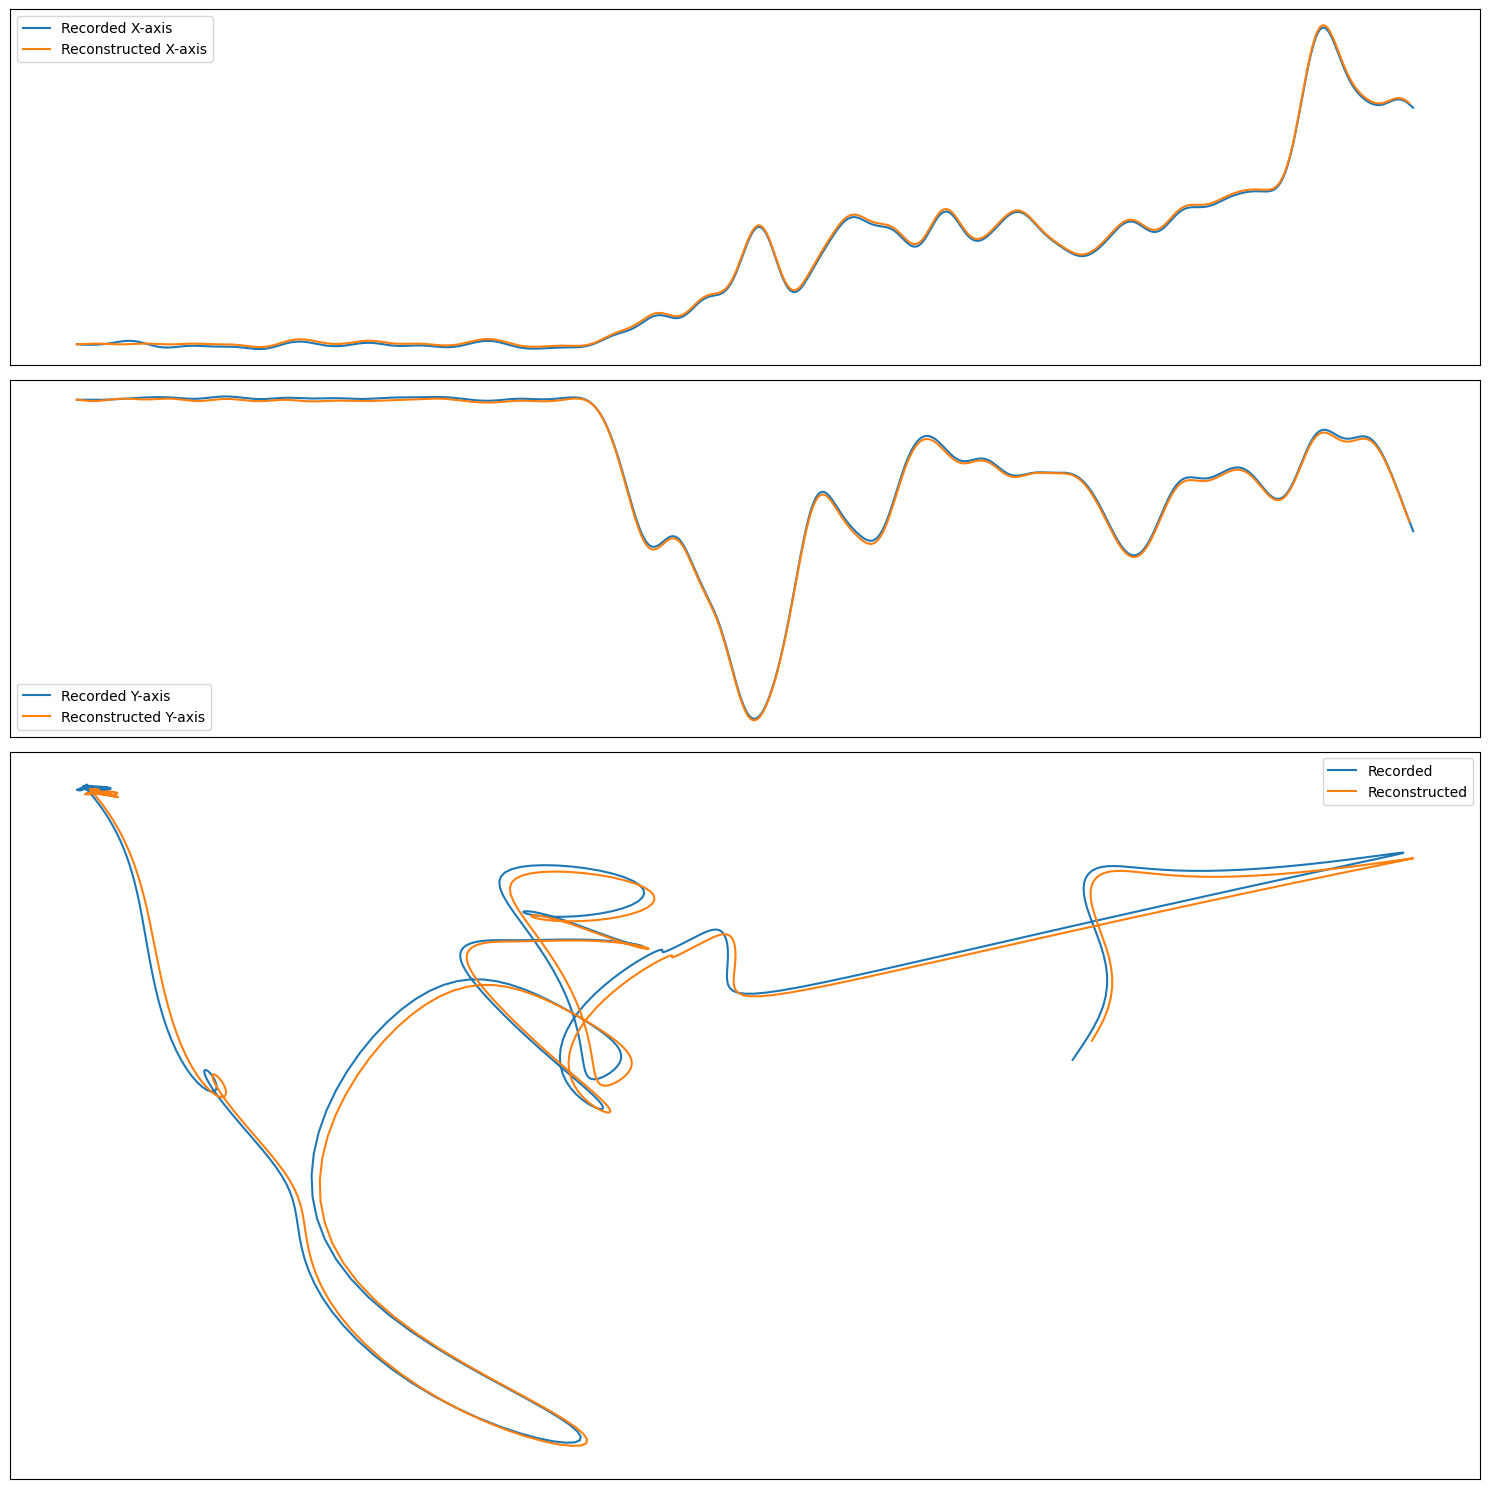

In [9]:
trim = 5
offset = [t.trajectory[0,-2]-state[0,trim], t.trajectory[0,-1]-state[1,trim]]
print(offset)
print(t.trajectory.shape)
print(state.shape)

# reconstruct_fig, axes = plt.subplots(3,1,figsize=(15, 45))
reconstruct_fig = plt.figure(constrained_layout=True, figsize=(15, 15))
spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=reconstruct_fig)
ax0 = reconstruct_fig.add_subplot(spec2[0, 0])
ax1 = reconstruct_fig.add_subplot(spec2[1, 0])
ax2 = reconstruct_fig.add_subplot(spec2[2:, 0])

ax0.plot(t.trajectory[:,-2],label="Recorded X-axis")
ax0.plot(state[0,trim:] + offset[0],label="Reconstructed X-axis")
ax0.set_xticks([])
ax0.set_yticks([])
ax0.legend()

ax1.plot(t.trajectory[:,-1],label="Recorded Y-axis")
ax1.plot(state[1,trim:] + offset[1],label="Reconstructed Y-axis")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.legend()

ax2.plot(t.trajectory[:,-2],t.trajectory[:,-1], label="Recorded")
ax2.plot(state[0,trim:] + offset[0], state[1,trim:] + offset[1], label="Reconstructed")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.legend()
reconstruct_fig.tight_layout()

In [18]:
reconstruct_fig.savefig(image_path / "analysis/reconstructed_trajectory.pdf", dpi=300, format="pdf")

Okay, not perfect, but I don't think there's anything fundamentally missing here, so we can write this up confidently.